In [79]:
%load_ext autoreload
%autoreload 2

from charting import create_performance_chart
from llm_service import litellm_service, custom_llm_service
from utils import get_llm_answers, get_llm_stats, load_all_llm_answers_from_json, model_clean
from auto_eval import (
    create_all_llm_eval_messages, 
    extract_all_scores, 
    create_auto_eval_json, 
    get_llm_eval_responses, 
    score_multiple_choice_answers,
    validation_func,
    extract_valid_json,
)
from multiple_choice import construct_multiple_choice_question
from hotz_reflection import construct_hotz_reflection_question

from datetime import datetime
import pandas as pd
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variables

In [80]:
answer_models = [
    "gpt-4-turbo-preview", 
    "gpt-4o",
    "meta.llama3-70b-instruct-v1:0", 
    "mistral/mistral-large-latest", 
    "mistral/open-mixtral-8x22b", 
    "claude-3-opus-20240229", 
    "vertex_ai/gemini-1.5-pro", 
    "vertex_ai/gemini-1.0-pro",
    "command-r", 
    "claude-3-5-sonnet-20240620",
]

answer_rounds = 10 # Number of rounds of questions to ask each model
answer_hyperparams = {
    'batch_size': 10, # Max number of questions to send to a model at once (10 is sensible)
    'temperature': 0, # 0 is default and the most deterministic
    'max_tokens': 2048, # 2048 works for most models, but may have to be reduced for some models
    'num_retries': 5, # Number of times to retry a question if it fails
}

multiple_choice_questions = True

if multiple_choice_questions is False:
    # Auto evaluation is only supported for open-ended questions and involves an LLM evaluating results against a set of criteria
    # Criteria can be found in `auto_eval.py` create_eval_prompt function
    auto_eval_rounds = 1 # Number of rounds of auto evaluation to run to then average the scores
    auto_eval_model = "gpt-4o"
    auto_eval_hyperparams= {
        'temperature': 0,
        'max_tokens': 2048,
        'batch_size': 30,
    }

hotz_reflection = True
benchmark_name = 'Benchmark' if not multiple_choice_questions else 'Multi-Benchmark'
date_now = datetime.now().strftime('%Y-%m-%d') #'2024-06-10'
folder_name = "2024-06-21-Multi-Benchmark (temp=0)" #f"{date_now}-{benchmark_name}"
answers_save_path = f"./{folder_name}/llm_outputs"
answers_hotz_save_path = f"./{folder_name}/hotz_reflection"
auto_eval_save_path = f"./{folder_name}/auto_eval_outputs"
auto_eval_hotz_save_path = f"./{folder_name}/auto_eval_hotz_outputs"
stats_save_path = f"./{folder_name}/tables_and_charts"


execution_steps = [
    # "get_llm_answers",
    # "hotz_reflection",
    # "evaluate_answers",
    "generate_statistics", 
]

## Run Benchmark

In [81]:
def calc_incomplete_llm_answers(all_llm_answers, auto_eval_save_path, sub_eval_folders, date_now):
    all_llm_evals = load_all_llm_answers_from_json(auto_eval_save_path,
        prefix_replace='auto_eval-', sub_folders=sub_eval_folders)
    skip_evals = set(all_llm_evals.keys() & set(all_llm_answers.keys()))
    print(f'Skipping existing LLM evals (in {date_now} folder):', skip_evals)
    incomplete_llm_answers = {model: value for model, value in all_llm_answers.items() 
                               if model_clean(model) not in skip_evals}
    return incomplete_llm_answers

1.5 GETTING HOTZ REFLECTION ANSWERS

----- Round: 1 of 10 -----
Skipping existing LLM answers (in 2024-07-01 folder): []
Running  Benchmark for gpt-4-turbo-preview
> Processing batch 1-10 ex 30
> Processing batch 11-20 ex 30
> Processing batch 21-30 ex 30
Running  Benchmark for gpt-4o
> Processing batch 1-10 ex 30
> Processing batch 11-20 ex 30
Validation failed on response 19. Retry #1
Validation failed on response 19. Retry #2
Validation failed on response 19. Retry #3
> Processing batch 21-30 ex 30
Running  Benchmark for meta.llama3-70b-instruct-v1:0
> Processing batch 1-10 ex 30
> Processing batch 11-20 ex 30
> Processing batch 21-30 ex 30
Running  Benchmark for mistral/mistral-large-latest
> Processing batch 1-10 ex 30
> Processing batch 11-20 ex 30
> Processing batch 21-30 ex 30
Running  Benchmark for mistral/open-mixtral-8x22b
> Processing batch 1-10 ex 30
> Processing batch 11-20 ex 30
> Processing batch 21-30 ex 30
Running  Benchmark for claude-3-opus-20240229
> Processing bat

,mean_score,std_dev_score,z_interval_error,ci_lower,ci_upper,output_count,invalid_outputs
model,,,,,,,
claude-3-5-sonnet-20240620,49.666667,50.082429,5.667360,44.333333,55.333333,300.0,0.0
gpt-4o,44.000000,49.721633,5.626532,38.333333,49.666667,300.0,0.0
claude-3-opus-20240229,43.000000,49.590295,5.611670,37.333333,48.666667,300.0,0.0
gpt-4-turbo-preview,35.000000,47.776654,5.406437,29.666667,40.341667,300.0,0.0
gemini-1_5-pro,31.333333,46.462365,5.257712,26.000000,36.666667,300.0,6.0
open-mixtral-8x22b,31.333333,46.462365,5.257712,26.333333,36.666667,300.0,8.0
meta_llama3-70b-instruct-v1_0,29.333333,45.605061,5.160699,24.333333,34.666667,300.0,2.0
mistral-large-latest,28.666667,45.296004,5.125725,23.666667,34.000000,300.0,2.0
command-r,25.000000,43.373620,4.908187,20.333333,30.000000,300.0,0.0


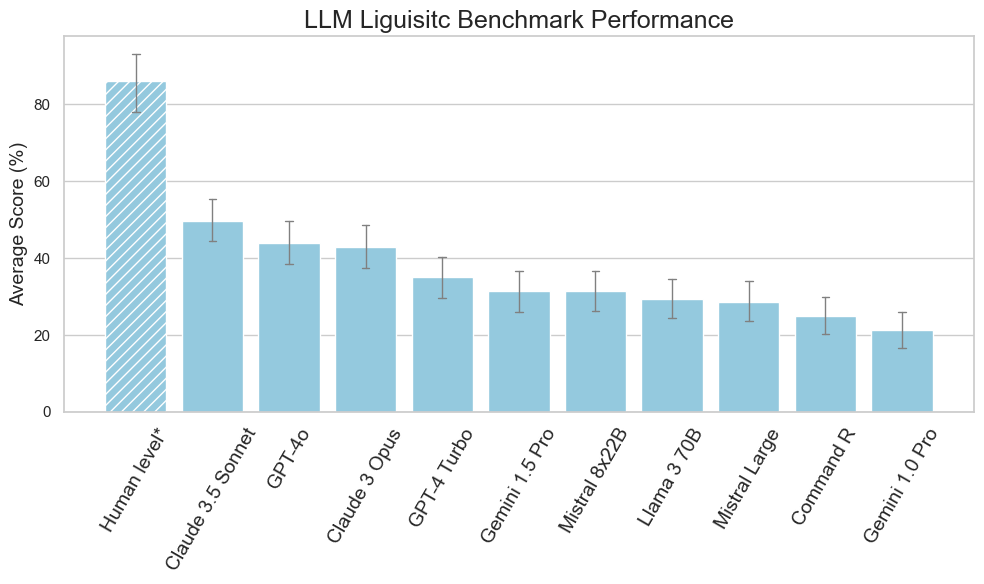

Eval for path: ./2024-06-21-Multi-Benchmark (temp=0)/auto_eval_hotz_outputs
Calculating stats for claude-3-5-sonnet-20240620
Calculating stats for claude-3-opus-20240229
Calculating stats for command-r
Calculating stats for gemini-1_0-pro
Calculating stats for gemini-1_5-pro
Calculating stats for gpt-4-turbo-preview
Calculating stats for gpt-4o
Calculating stats for meta_llama3-70b-instruct-v1_0
Calculating stats for mistral-large-latest
Calculating stats for open-mixtral-8x22b
claude-3-5-sonnet-20240620 1
claude-3-opus-20240229 1
command-r 0
gemini-1_0-pro 0
gemini-1_5-pro 1
gpt-4-turbo-preview 0
gpt-4o 2
meta_llama3-70b-instruct-v1_0 5
mistral-large-latest 0
open-mixtral-8x22b 0


,mean_score,std_dev_score,z_interval_error,ci_lower,ci_upper,output_count,invalid_outputs
model,,,,,,,
claude-3-5-sonnet-20240620,45.000000,49.832495,5.639078,39.333333,50.666667,300.0,1.0
gpt-4o,41.666667,49.383039,5.588217,36.000000,47.333333,300.0,2.0
claude-3-opus-20240229,40.333333,49.138623,5.560559,34.666667,46.000000,300.0,1.0
gpt-4-turbo-preview,33.666667,47.335940,5.356566,28.333333,39.000000,300.0,0.0
gemini-1_5-pro,32.333333,46.853028,5.301919,27.000000,37.666667,300.0,1.0
open-mixtral-8x22b,30.333333,46.046605,5.210664,25.000000,35.666667,300.0,0.0
mistral-large-latest,29.000000,45.452022,5.143380,24.000000,34.000000,300.0,0.0
meta_llama3-70b-instruct-v1_0,27.666667,44.809768,5.070703,22.666667,32.666667,300.0,5.0
command-r,22.666667,41.937470,4.745671,18.000000,27.666667,300.0,0.0


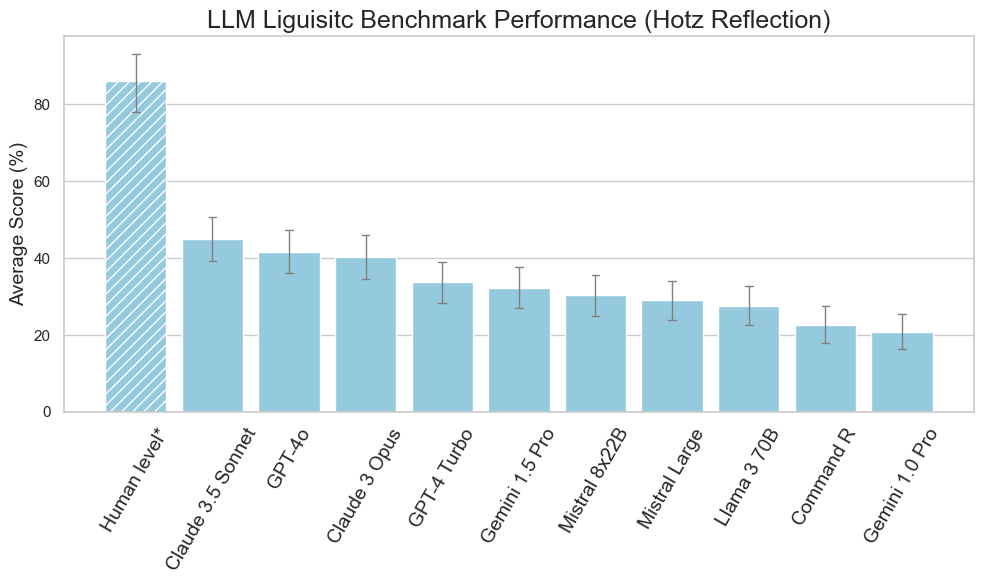

-- DONE STATS --



In [82]:
# Load in benchmark questions
if multiple_choice_questions:
    benchmark_questions = json.load(open('linguistic_benchmark_multi_choice.json', 'r'))
    sub_eval_folders = ['']
    def answer_validation_func(x):
        return validation_func(x, json_key='ANSWER', list_of_values=['A', 'B', 'C', 'D'])
else:
    benchmark_questions = json.load(open('linguistic_benchmark.json', 'r'))
    sub_eval_folders = [f'/round_{r+1}' for r in range(auto_eval_rounds)]
sub_answer_folders = [f'/round_{r+1}' for r in range(answer_rounds)]


if "get_llm_answers" in execution_steps:
    print('1. GETTING LLM ANSWERS')
    # Load in any existing answers and evals to avoid overwriting them
    for n in range(answer_rounds):
        print(f'\n----- Round: {n+1} of {answer_rounds} -----')
        answer_save_path_round = f"{answers_save_path}/round_{n+1}"
        all_llm_answers = load_all_llm_answers_from_json(answer_save_path_round,
            prefix_replace='final_answers-')
        print(f'Skipping existing LLM answers (in {answer_save_path_round} folder):', list(all_llm_answers.keys()))
        answer_models_run = [model for model in answer_models 
                            if model_clean(model) not in all_llm_answers.keys()]
        if multiple_choice_questions:
            for q in benchmark_questions:
                prompt, correct_letter = construct_multiple_choice_question(q)
                q.update({'multi_choice_question': prompt, 'correct_letter': correct_letter})
        questions = {m: benchmark_questions for m in answer_models_run}
        all_llm_answers = await get_llm_answers(
            litellm_service(),
            benchmark_questions,
            answer_models_run,
            answer_hyperparams,
            answer_save_path_round,
            multiple_choice_questions,
            validation_func=answer_validation_func if multiple_choice_questions else lambda x: True
        )
    print('-- DONE ANSWERS --\n')


if "hotz_reflection" in execution_steps:
    print('1.5 GETTING HOTZ REFLECTION ANSWERS')
    # Load in any existing answers and evals to avoid overwriting them
    for n in range(answer_rounds):
        print(f'\n----- Round: {n+1} of {answer_rounds} -----')
        answer_save_path_round = f"{answers_save_path}/round_{n+1}"
        answer_hotz_save_path_round = f"{answers_hotz_save_path}/round_{n+1}"
        all_llm_answers = load_all_llm_answers_from_json(answer_save_path_round,
            prefix_replace='final_answers-')
        all_hotz_llm_answers = load_all_llm_answers_from_json(answer_hotz_save_path_round,
            prefix_replace='final_answers-')
        print(f'Skipping existing LLM answers (in {answer_hotz_save_path_round} folder):', list(all_hotz_llm_answers.keys()))
        answer_models_run = [model for model in answer_models 
                            if model_clean(model) not in all_hotz_llm_answers.keys()]
        all_llm_questions = {model: info.to_dict('records') for model, info in all_llm_answers.items()}
        if multiple_choice_questions:
            for model, questions in all_llm_questions.items():
                for q in questions:
                    prompt = construct_hotz_reflection_question(q)
                    q.update({'multi_choice_question_pre': q['multi_choice_question']})
                    q.update({'model_answer_pre': q['model_answer']})
                    q.update({'multi_choice_question': prompt})

        all_llm_answers = await get_llm_answers(
            litellm_service(),
            all_llm_questions,
            answer_models_run,
            answer_hyperparams,
            answer_hotz_save_path_round,
            multiple_choice_questions,
            validation_func=answer_validation_func if multiple_choice_questions else lambda x: True
        )
    print('-- DONE ANSWERS --\n')


if "evaluate_answers" in execution_steps:
    print('2. EVALUATING ANSWERS')
    all_llm_answers = load_all_llm_answers_from_json(answers_save_path,
        prefix_replace='final_answers-', sub_folders=sub_answer_folders)
    if multiple_choice_questions:
        incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_answers, auto_eval_save_path,
                                                             sub_eval_folders, date_now)
        all_llm_evals = score_multiple_choice_answers(incomplete_llm_answers, auto_eval_save_path)
        if hotz_reflection:
            print('\nEvaluate Hotz Reflections')
            all_llm_answers = load_all_llm_answers_from_json(answers_hotz_save_path,
                prefix_replace='final_answers-', sub_folders=sub_answer_folders)
            incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_answers, auto_eval_hotz_save_path,
                                                                sub_eval_folders, date_now)
            all_llm_evals = score_multiple_choice_answers(incomplete_llm_answers, auto_eval_hotz_save_path)
    else:
        all_llm_eval_messages = create_all_llm_eval_messages(all_llm_answers, benchmark_questions)
        for n in range(auto_eval_rounds):
            print(f'- Round: {n+1} of {auto_eval_rounds} -')
            incomplete_llm_answers = calc_incomplete_llm_answers(all_llm_eval_messages, auto_eval_save_path,
                                                                 [f'/round_{n+1}'], date_now)
            all_llm_eval_responses = await get_llm_eval_responses(
                custom_llm_service(), 
                incomplete_llm_answers,
                model=auto_eval_model, 
                hyperparams=auto_eval_hyperparams,
                validation_func=lambda x: validation_func(x, json_key='score', 
                    list_of_values=[0, 20, 40, 60, 80, 100])
            )
            all_llm_scores = extract_all_scores(all_llm_eval_responses)
            auto_eval_save_path_n = f"{auto_eval_save_path}/round_{n+1}"
            all_auto_results = create_auto_eval_json(
                all_llm_scores, 
                all_llm_eval_responses, 
                all_llm_answers, 
                benchmark_questions, 
                auto_eval_save_path_n
            )
    print('-- DONE EVAL --\n')


if "generate_statistics" in execution_steps:
    print('3. GENERATING STATISTICS')
    all_stats_dfs = {}
    save_info = [{
        'path': auto_eval_save_path, 
        'chart_title': 'LLM Liguisitc Benchmark Performance'
    }]
    if hotz_reflection:
        save_info.append({
            'path': auto_eval_hotz_save_path, 
            'chart_title': 'LLM Liguisitc Benchmark Performance (Hotz Reflection)'
        })
    for info in save_info:
        save_path = info['path']
        chart_title = info['chart_title']
        print('Eval for path:', save_path)
        all_llm_evals = load_all_llm_answers_from_json(
            save_path, 
            prefix_replace='auto_eval-',
            sub_folders=sub_eval_folders,
        )
        stats_df = get_llm_stats(all_llm_evals, stats_save_path, bootstrap_n=10000)
        if multiple_choice_questions:
            for model, evals_df in all_llm_evals.items():
                #evals_df['invalid_answer_letter'] = evals_df.apply(lambda x: x['json_answer_letter'] not in ['A', 'B', 'C', 'D'], axis=1)
                incorrect_letter_count = evals_df['invalid_answer_letter'].sum()
                print(model, incorrect_letter_count)
                stats_df.loc[model, 'invalid_outputs'] = incorrect_letter_count

        display(stats_df)
        barplot, plt = create_performance_chart(stats_df.reset_index(), chart_title)
        barplot.figure.savefig(f"{stats_save_path}/performance_chart.png")
        plt.show()
        all_stats_dfs[chart_title] = stats_df
    print('-- DONE STATS --\n')

## Inspect Answers for a given model

In [113]:
# model = 'gpt-4-turbo-preview'
# answers = all_llm_evals[model][['question', 'model_answer', 'json_answer', 'correct_letter', 'score']]
# for row in answers.to_dict('records'):
#     print('--------------')
#     print('\nQuestion\n', row['question'])
#     print('\nModel Answer\n', row['model_answer'])
#     print('\nJson Answer\n', row['json_answer'])
#     print('\nCorrect Letter\n', row['correct_letter'])    
#     print('\nScore\n', row['score'])

## Inspect Hotz Reflections Performance

In [132]:
all_llm_evals = load_all_llm_answers_from_json(
    auto_eval_hotz_save_path, 
    prefix_replace='auto_eval-',
    sub_folders=sub_eval_folders,
)

answer_change_stats = {}
for model, model_evals in all_llm_evals.items():
    model_evals['json_answer_letter_pre'] = model_evals['model_answer_pre'].map(extract_valid_json).map(lambda x: None if x is None else x['ANSWER'])

    compare_letters = model_evals[['json_answer_letter', 'json_answer_letter_pre', 'correct_letter']].copy()
    compare_letters['changed_answer'] = compare_letters['json_answer_letter'] != compare_letters['json_answer_letter_pre']
    compare_letters['changed_answer_perc'] = (compare_letters['changed_answer'] / len(compare_letters)) * 100
    compare_letters['correct'] = compare_letters['json_answer_letter'] == compare_letters['correct_letter']
    compare_letters['correct_pre'] = compare_letters['json_answer_letter_pre'] == compare_letters['correct_letter']

    compare_letters[['correct', 'correct_pre', 'changed_answer_perc']].sum()
    answer_change_stats[model] = compare_letters[['correct_pre', 'correct', 'changed_answer_perc']].sum()
final_answer_change_df = pd.DataFrame(answer_change_stats).transpose().sort_values('correct', ascending=False)
final_answer_change_df.rename(columns={
    'correct_pre': 'Correct (pre-reflection)', 
    'correct': 'Correct (post-reflection)', 
    }, inplace=True)
final_answer_change_df

,Correct (pre-reflection),Correct (post-reflection),changed_answer_perc
claude-3-5-sonnet-20240620,149.0,135.0,24.666667
gpt-4o,132.0,125.0,9.666667
claude-3-opus-20240229,129.0,121.0,12.000000
gpt-4-turbo-preview,105.0,101.0,14.666667
gemini-1_5-pro,94.0,97.0,29.666667
open-mixtral-8x22b,94.0,91.0,5.333333
mistral-large-latest,86.0,87.0,9.000000
meta_llama3-70b-instruct-v1_0,88.0,83.0,45.666667
command-r,75.0,68.0,7.333333
gemini-1_0-pro,64.0,62.0,6.666667


In [125]:
hotz_ref = 'LLM Liguisitc Benchmark Performance (Hotz Reflection)'
ref = 'LLM Liguisitc Benchmark Performance'

all_stats_dfs[hotz_ref]['mean_score_pre'] = all_stats_dfs[ref]['mean_score']

all_stats_dfs[hotz_ref]['diff'] = all_stats_dfs[hotz_ref]['mean_score'] - all_stats_dfs[hotz_ref]['mean_score_pre']
all_stats_dfs[hotz_ref]
diff_from_pre = all_stats_dfs[hotz_ref][['mean_score', 'mean_score_pre', 'diff']]
diff_from_pre

,mean_score,mean_score_pre,diff
model,,,
claude-3-5-sonnet-20240620,45.000000,49.666667,-4.666667
gpt-4o,41.666667,44.000000,-2.333333
claude-3-opus-20240229,40.333333,43.000000,-2.666667
gpt-4-turbo-preview,33.666667,35.000000,-1.333333
gemini-1_5-pro,32.333333,31.333333,1.000000
open-mixtral-8x22b,30.333333,31.333333,-1.000000
mistral-large-latest,29.000000,28.666667,0.333333
meta_llama3-70b-instruct-v1_0,27.666667,29.333333,-1.666667
command-r,22.666667,25.000000,-2.333333


In [133]:
diff_from_pre_final_raw = diff_from_pre.merge(final_answer_change_df[['changed_answer_perc']], left_index=True, right_index=True)
diff_from_pre_final = diff_from_pre_final_raw[['mean_score_pre', 'mean_score', 'diff', 'changed_answer_perc']].round(0)
diff_from_pre_final.rename(columns={
    "mean_score_pre": "Pre-Reflection Score",
    "mean_score": "Post-Reflection Score",
    "diff": "Difference",
    "changed_answer_perc": "Answers Changed (%)",
}, inplace=True)
diff_from_pre_final = diff_from_pre_final.astype(int).astype(str) + '%'
diff_from_pre_final

,Pre-Reflection Score,Post-Reflection Score,Difference,Answers Changed (%)
claude-3-5-sonnet-20240620,50%,45%,-5%,25%
gpt-4o,44%,42%,-2%,10%
claude-3-opus-20240229,43%,40%,-3%,12%
gpt-4-turbo-preview,35%,34%,-1%,15%
gemini-1_5-pro,31%,32%,1%,30%
open-mixtral-8x22b,31%,30%,-1%,5%
mistral-large-latest,29%,29%,0%,9%
meta_llama3-70b-instruct-v1_0,29%,28%,-2%,46%
command-r,25%,23%,-2%,7%
gemini-1_0-pro,21%,21%,-1%,7%


# Inspect Auto Eval Consistancy

In [ ]:
all_llm_evals = load_all_llm_answers_from_json(
    auto_eval_save_path, 
    prefix_replace='auto_eval-',
    sub_folders=sub_eval_folders,
)
models = list(all_llm_evals.keys())


model = models[3]
print(f"Model: {model}")
auto_eval_agg = all_llm_evals[model].set_index('level_0').groupby('index').agg({'score': ['mean', 'min', 'max']})
auto_eval_agg.index.name = 'Question #'
auto_eval_agg

Model: gemini-1_0-pro


score          
             mean  min  max
Question #                 
1             0.0    0    0
2             0.0    0    0
3            20.0    0  100
4             0.0    0    0
5            80.0    0  100
6            60.0    0  100
7            30.0    0  100
8            10.0    0  100
9             0.0    0    0
10           10.0    0  100
11           50.0    0  100
12           10.0    0  100
13           10.0    0  100
14            0.0    0    0
15            0.0    0    0
16          100.0  100  100
17            0.0    0    0
18           10.0    0  100
19            0.0    0    0
20           20.0    0  100
21           20.0    0  100
22           20.0    0  100
23           30.0    0  100
24            0.0    0    0
25           70.0    0  100
26            0.0    0    0
27            0.0    0    0
28           50.0    0  100
29           10.0    0  100
30           10.0    0  100

In [ ]:
# tables_folder = "2024-06-12-Multi-Benchmark (temp=1)/tables_and_charts"
# stats_df = pd.read_csv(f"{tables_folder}/final_stats.csv", index_col=0)
# barplot, plt = create_performance_chart(stats_df.reset_index())
# barplot.figure.savefig(f"{tables_folder}/performance_chart.png")